In [44]:
LSTM_HYPERPARAMS = [8,16,32,64]
DENSE_HYPERPARAMS = [8,16,32,64]

In [45]:
from matplotlib import pyplot as plt
import numpy as np
import os
import random
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, LSTM, Dropout

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# resample signal to n samples
from scipy.signal import resample

# XML parser
import xml.etree.ElementTree as ET

# encoding and normalizing data
from sklearn.preprocessing import LabelEncoder, StandardScaler

NUM_POINTS = 50

In [46]:
data = []

for root, subdirs, files in os.walk('xml_logs'):
    if 'ipynb_checkpoint' in root:
        continue
    
    if len(files) > 0:
        for f in tqdm(files):
            if f.endswith('.xml'):
                fname = f.split('.')[0]
                label = fname[:-2]
                
                xml_root = ET.parse(f'{root}/{f}').getroot()
                
                points = []
                for element in xml_root.findall('Point'):
                    x = element.get('X')
                    y = element.get('Y')
                    points.append([x, y])
                    
                points = np.array(points, dtype=float)
                
                scaler = StandardScaler()
                points = scaler.fit_transform(points)
                
                resampled = resample(points, NUM_POINTS)
                
                data.append((label, resampled))

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

In [47]:
# Prepare the data
labels = [sample[0] for sample in data]
print(labels)

encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

print(set(labels_encoded))

y = to_categorical(labels_encoded)

print(len(y[0]))

sequences = [sample[1] for sample in data]
X = np.array(sequences)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

['arrow', 'arrow', 'arrow', 'arrow', 'arrow', 'arrow', 'arrow', 'arrow', 'arrow', 'arrow', 'caret', 'caret', 'caret', 'caret', 'caret', 'caret', 'caret', 'caret', 'caret', 'caret', 'check', 'check', 'check', 'check', 'check', 'check', 'check', 'check', 'check', 'check', 'circle', 'circle', 'circle', 'circle', 'circle', 'circle', 'circle', 'circle', 'circle', 'circle', 'delete_mark', 'delete_mark', 'delete_mark', 'delete_mark', 'delete_mark', 'delete_mark', 'delete_mark', 'delete_mark', 'delete_mark', 'delete_mark', 'left_curly_brace', 'left_curly_brace', 'left_curly_brace', 'left_curly_brace', 'left_curly_brace', 'left_curly_brace', 'left_curly_brace', 'left_curly_brace', 'left_curly_brace', 'left_curly_brace', 'left_sq_bracket', 'left_sq_bracket', 'left_sq_bracket', 'left_sq_bracket', 'left_sq_bracket', 'left_sq_bracket', 'left_sq_bracket', 'left_sq_bracket', 'left_sq_bracket', 'left_sq_bracket', 'pigtail', 'pigtail', 'pigtail', 'pigtail', 'pigtail', 'pigtail', 'pigtail', 'pigtail', '

In [48]:
df = pd.DataFrame(columns=['lstm_units', 'dense_units', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy', 'total_params'])

The higher the lstm_units, the more parameters the model has.
Adding a Dropout layer did not change the parametercount.

In [49]:
def create_model(params):
    lstm_param, dense_param = params
    # Define the model
    model = Sequential()

    # add LSTM layer
    # input shape is (length of an individual sample, dimensions of the sample)
    # in our case: two dimensions, as we have X and Y coordinates

    # old syntax
    #model.add(LSTM(64, input_shape=(NUM_POINTS, 2)))

    # new syntax
    model.add(Input((NUM_POINTS, 2)))
    model.add(LSTM(lstm_param))

    # add dense layer to do machine learning magic
    model.add(Dense(dense_param, activation='relu'))

    # here, you can add more layers and maybe a dropout for better performance

    # softmax layer for classification
    model.add(Dense(len(set(labels)), activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
    stop_early = EarlyStopping(monitor='val_loss', patience=3)
    return model, reduce_lr, stop_early

In [50]:
all_models = []
for lstm in LSTM_HYPERPARAMS:
    for dense in DENSE_HYPERPARAMS:
        param = (lstm, dense)
        print(f"Training model with {param}...")
        model, reduce_lr, stop_early = create_model(param)
        # Train the model
        history = model.fit(
            X_train,
            y_train,
            epochs=10,
            batch_size=32,
            validation_data=(X_test, y_test),
            verbose=1,
            callbacks=[reduce_lr, stop_early]
        )
        df.loc[len(df)] = [lstm, dense, history.history['loss'][-1], history.history['accuracy'][-1], history.history['val_loss'][-1], history.history['val_accuracy'][-1], model.count_params()]
        all_models.append(model)

Training model with (8, 8)...
Epoch 1/10


AttributeError: module 'keras.src.backend' has no attribute 'convert_to_numpy'

In [ ]:
model.summary()

Model: "sequential_104"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_104 (LSTM)                 │ (None, 64)             │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_208 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_209 (Dense)               │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,058 (261.95 KB)

 Trainable params: 22,352 (87.31 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 44,706 (174.64 KB)

In [ ]:
df


,lstm_units,dense_units,train_loss,train_accuracy,val_loss,val_accuracy,total_params
0,8.0,8.0,0.460936,0.888258,0.424780,0.888258,568.0
1,8.0,16.0,0.348890,0.890152,0.336823,0.880682,768.0
2,8.0,32.0,0.331765,0.887547,0.313636,0.884470,1168.0
3,8.0,64.0,0.198453,0.937263,0.193290,0.949811,1968.0
4,16.0,8.0,0.240943,0.969223,0.217578,0.964015,1496.0
5,16.0,16.0,0.098603,0.974669,0.097068,0.976326,1760.0
6,16.0,32.0,0.071255,0.982008,0.081953,0.980114,2288.0
7,16.0,64.0,0.055341,0.986979,0.097842,0.973485,3344.0
8,32.0,8.0,0.094098,0.977983,0.084482,0.984848,4888.0
9,32.0,16.0,0.043944,0.991004,0.060237,0.986742,5280.0


<Axes: xlabel='lstm_units'>

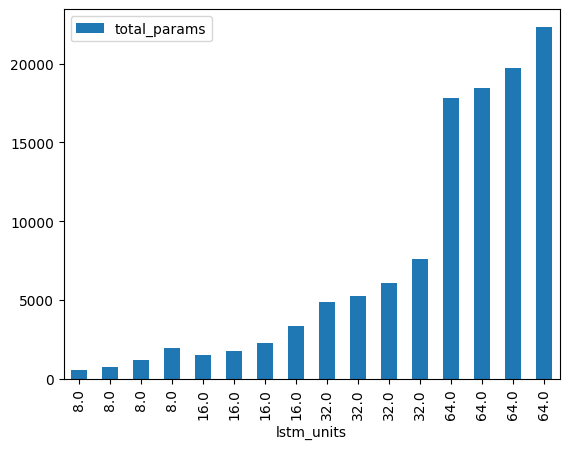

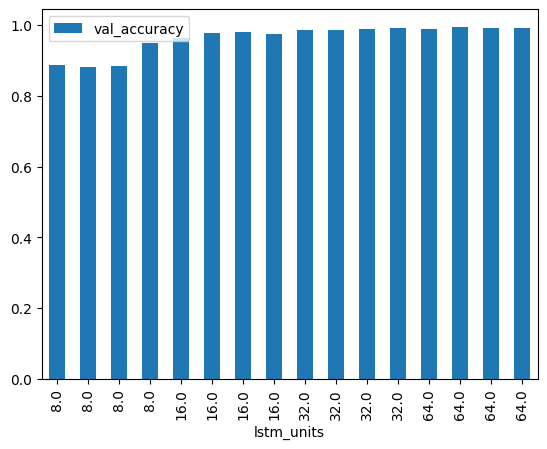

In [ ]:
df.plot(x='lstm_units', y='total_params', kind='bar')
df.plot(x='lstm_units', y='val_accuracy', kind='bar')

In [ ]:

def plot_3d(df, axis1, axis2, axis3):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')

    lstm_units_unique = df[axis1].unique()
    dense_units_unique = df[axis2].unique()

    lstm_units_map = {unit: i for i, unit in enumerate(lstm_units_unique)}
    dense_units_map = {unit: i for i, unit in enumerate(dense_units_unique)}

    x = df[axis2].map(dense_units_map).values
    y = df[axis1].map(lstm_units_map).values

    top = df[axis3].values
    bottom = np.zeros_like(top)
    width = depth = 1

    # Normalize to [0,1]
    norm = plt.Normalize(top.min(), top.max())
    colors = cm.viridis(norm(top))

    ax.bar3d(x, y, bottom, width, depth, top, color=colors, shade=True)
    ax.set_xlabel(axis2)
    ax.set_ylabel(axis1)
    ax.set_zlabel(axis3)

    ax.set_xticks(range(len(dense_units_unique)))
    ax.set_xticklabels(dense_units_unique)

    ax.set_yticks(range(len(lstm_units_unique)))
    ax.set_yticklabels(lstm_units_unique)

    plt.show()

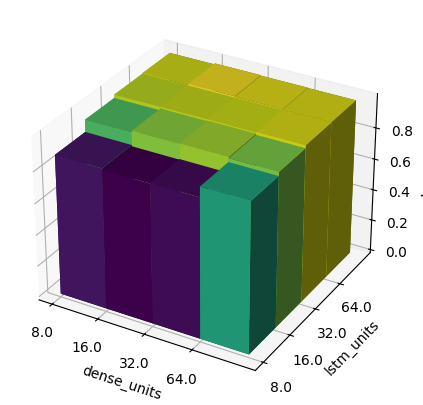

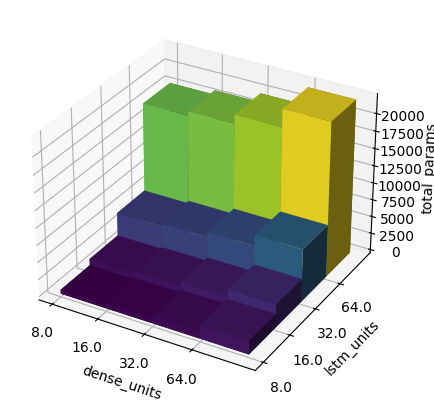

In [ ]:
plot_3d(df, 'lstm_units', 'dense_units', 'val_accuracy')
plot_3d(df, 'lstm_units', 'dense_units', 'total_params')

As seen in the Plots, the higher the lstm_units, the more parameters the model has.
Also the higher the dense_units, the more parameters the model has, but this does not have as big of an impact as the ltsm_units.

Looking at the accuracy, everything above 16 ltms_units has about the same accuracy.
Almost the same goes for the dense_units, everything has about the same accuracy.

## Comparing two of the models + the $1 recognizer

Due to accuracy being the same for almost all the models, i chose the model with 16 lstm_units and 8 dense_units and the one with 32 lstm_units and 16 dense_units to compare.


## Errors:

Somehow ALL models have an accuracy of 0.0. I checked the xml data and compared it with the training data, there is no difference (see plots below). I also checked the code and the model, but I could not find the error. I did everything as in the exercise.

Most of the times the model predicts the same class for a class, but it's not the right one.

In [ ]:
# get test data from '../dataset/.xml' files
test_data = []
for root, subdirs, files in os.walk('../dataset'):
    if 'ipynb_checkpoints' in root:
        continue

    if len(files) > 0:
        for f in tqdm(files):
            if f.endswith('.xml'):
                xml_root = ET.parse(f'{root}/{f}').getroot()

                points = []
                for element in xml_root.findall('Point'):
                    x = element.get('X')
                    y = element.get('Y')
                    points.append([x, y])

                points = np.array(points, dtype=float)

                scaler = StandardScaler()
                points = scaler.fit_transform(points)

                resampled = resample(points, NUM_POINTS)

                label = xml_root.get('Name')

                test_data.append((label, resampled))

  0%|          | 0/161 [00:00<?, ?it/s]

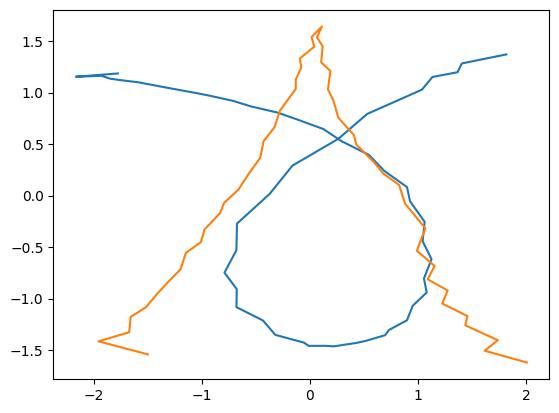

In [ ]:
random_test = random.sample(test_data, 1)[0]

label = random_test[0]
sequence = random_test[1]
sequence

plt.plot(sequence.T[0], sequence.T[1]*-1)

random_test = random.sample(data, 1)[0]

label = random_test[0]
sequence = random_test[1]
sequence

plt.plot(sequence.T[0], sequence.T[1]*-1)

In [ ]:
labels = [sample[0] for sample in test_data]

test_encoder = LabelEncoder()
labels_encoded = test_encoder.fit_transform(labels)

# split the test_data into data and labels for x_test and y_test
y_test, X_test = zip(*test_data)
y_test = np.array(y_test)
X_test = np.array(X_test)

all_accuracies = []

for model in all_models:
    # predict the test data
    y_pred = model.predict(X_test)
    prediction = np.argmax(y_pred, axis=1)
    #print('Prediction:', prediction)
    prediction_label = test_encoder.inverse_transform(prediction)
    
    all_accuracies.append(np.mean(prediction == y_test))
    print('Accuracy:', np.mean(prediction == y_test))

df['test_accuracy'] = all_accuracies

df

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Accuracy: 0.0
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Accuracy: 0.0
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Accuracy: 0.0
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Accuracy: 0.0
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Accuracy: 0.0
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Accuracy: 0.0
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Accuracy: 0.0
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Accuracy: 0.0
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Accuracy: 0.0
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Accuracy: 0.0
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Accuracy: 0.0
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Accuracy: 0.0
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Accuracy: 0.0
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Accuracy: 0.0
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Accuracy: 0.0
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Accuracy: 0.0


,lstm_units,dense_units,train_loss,train_accuracy,val_loss,val_accuracy,total_params,test_accuracy
0,8.0,8.0,0.460936,0.888258,0.424780,0.888258,568.0,0.0
1,8.0,16.0,0.348890,0.890152,0.336823,0.880682,768.0,0.0
2,8.0,32.0,0.331765,0.887547,0.313636,0.884470,1168.0,0.0
3,8.0,64.0,0.198453,0.937263,0.193290,0.949811,1968.0,0.0
4,16.0,8.0,0.240943,0.969223,0.217578,0.964015,1496.0,0.0
5,16.0,16.0,0.098603,0.974669,0.097068,0.976326,1760.0,0.0
6,16.0,32.0,0.071255,0.982008,0.081953,0.980114,2288.0,0.0
7,16.0,64.0,0.055341,0.986979,0.097842,0.973485,3344.0,0.0
8,32.0,8.0,0.094098,0.977983,0.084482,0.984848,4888.0,0.0
9,32.0,16.0,0.043944,0.991004,0.060237,0.986742,5280.0,0.0


## Results:

If the models would have worked, my guess is that the model with 16 lstm_units and 8 dense_units would have been the best, because it has the least parameters and the accuracy is about the same as the other models.